In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

set_config(transform_output="pandas")

In [20]:
df = pd.read_csv("hotel_bookings.csv")

In [21]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [22]:
numerical_features = [
    "lead_time", "adr", "previous_cancellations", "previous_bookings_not_canceled",
    "booking_changes", "days_in_waiting_list", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "required_car_parking_spaces", "total_of_special_requests", "arrival_date_week_number", "agent", "company"
]

categorical_features = [
    "hotel", "customer_type", "market_segment", "distribution_channel",
    "deposit_type", "meal", "reserved_room_type", "assigned_room_type", "is_repeated_guest"
]

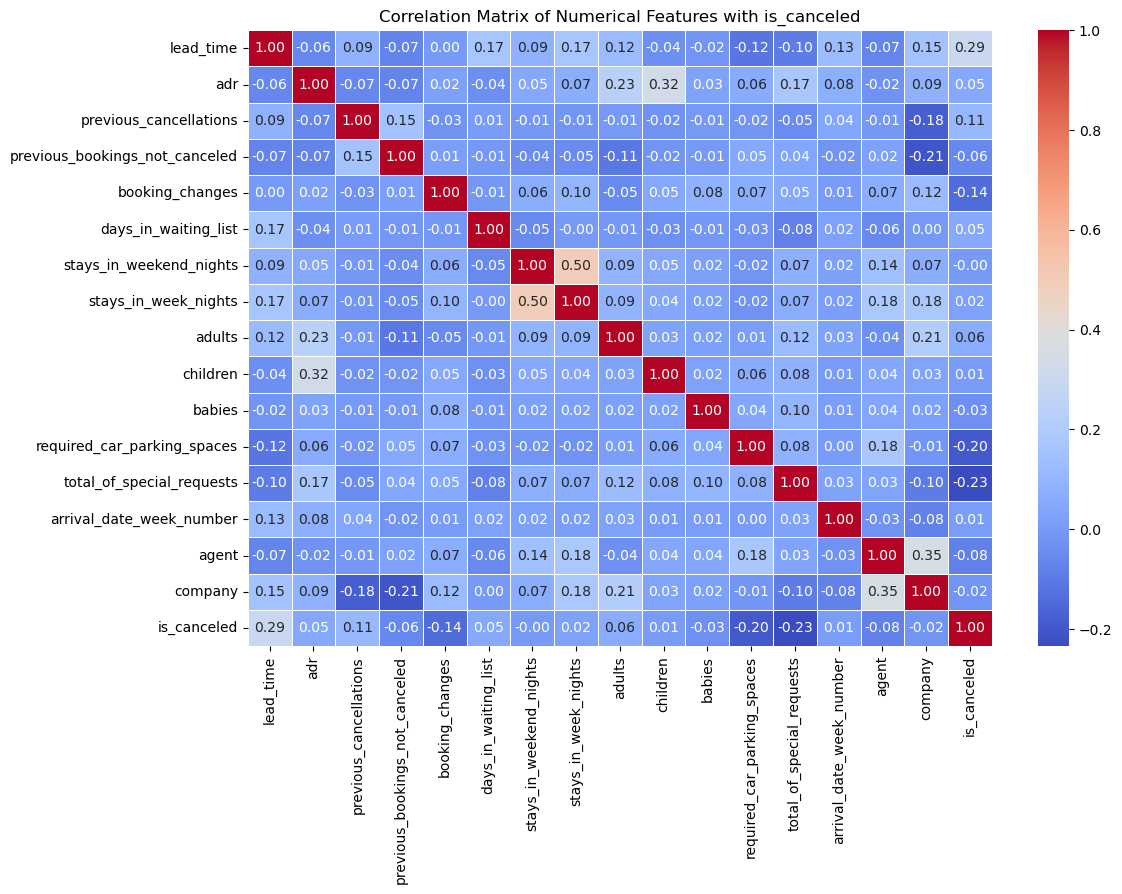

In [23]:
# Multicollinearity and correlation with target variable
# Compute correlation matrix for numerical features
corr_matrix = df[numerical_features + ["is_canceled"]].corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features with is_canceled")
plt.show()

In [24]:
# update the numerical features we will use, after checking correlation with target variable
# discarded num features: babies, children, stays_in_weekend_nights, stays_in_week_nights, arrival_date_week_number
# threshold to discard feature based on correlation tih target: correlation < 0.5
numerical_features = [
    "lead_time", "adr", "previous_cancellations",
    "previous_bookings_not_canceled", "booking_changes",
    "days_in_waiting_list", "adults","required_car_parking_spaces",
    "total_of_special_requests", "agent", "company"
]

In [25]:
X = df.drop(columns=["is_canceled"])
y = df["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

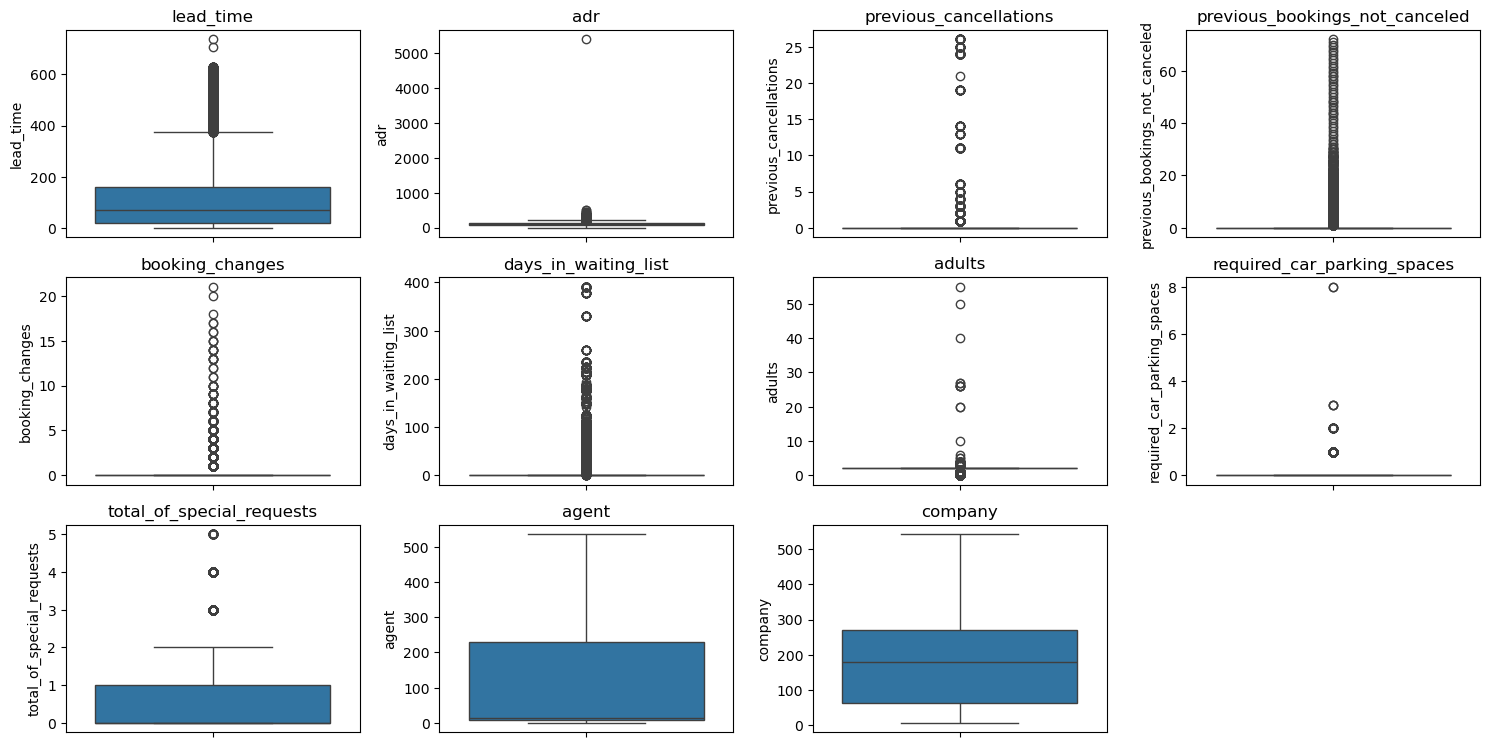

In [26]:
# Handle outliers? -> Not necessary

# Create boxplots for each numerical feature
plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features):
    plt.subplot(4, 4, i + 1)  # Adjust grid size based on number of features
    sns.boxplot(y=df[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()


In [27]:
df[numerical_features].describe()

,lead_time,adr,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adults,required_car_parking_spaces,total_of_special_requests,agent,company
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000
mean,104.011416,101.831122,0.087118,0.137097,0.221124,2.321149,1.856403,0.062518,0.571363,86.693382,189.266735
std,106.863097,50.535790,0.844336,1.497437,0.652306,17.594721,0.579261,0.245291,0.792798,110.774548,131.655015
min,0.000000,-6.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000
25%,18.000000,69.290000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,9.000000,62.000000
50%,69.000000,94.575000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,14.000000,179.000000
75%,160.000000,126.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,229.000000,270.000000
max,737.000000,5400.000000,26.000000,72.000000,21.000000,391.000000,55.000000,8.000000,5.000000,535.000000,543.000000


In [ ]:
imputer_0 = SimpleImputer(strategy="constant", fill_value=0)

meal_categories = [["Undefined", "SC", "HB", "BB", "FB"]]
# room_types = [
#     ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"],
#     ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"]
# ]
categorical_features_to_ordinal = ["meal", "reserved_room_type", "assigned_room_type"]
ordinal_encoder_meals = OrdinalEncoder(categories=meal_categories)
# ordinal_encoder_room_type = OrdinalEncoder(categories=room_types)

reserved_room_categories = [sorted(df["reserved_room_type"].dropna().unique())]
assigned_room_categories = [sorted(df["assigned_room_type"].dropna().unique())]
ordinal_encoder_reserved = OrdinalEncoder(categories=reserved_room_categories, handle_unknown="use_encoded_value", unknown_value=-1)
ordinal_encoder_assigned = OrdinalEncoder(categories=assigned_room_categories, handle_unknown="use_encoded_value", unknown_value=-1)


onehot_encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

In [29]:
preprocessor = ColumnTransformer([
    ("onehot_encoder", onehot_encoder, [x for x in categorical_features if x not in categorical_features_to_ordinal]),
    ("ordinal_encoder_meals", ordinal_encoder_meals, ["meal"]),
    ("ordinal_encoder_reserved", ordinal_encoder_reserved, ["reserved_room_type"]),
    ("ordinal_encoder_assigned", ordinal_encoder_assigned, ["assigned_room_type"]),
    ("agent_company_imputer", imputer_0, ["agent", "company"])
])


In [30]:
pipe = Pipeline([('preprocess', preprocessor),('scaler', scaler),('ml_model', LogisticRegression())])
pipe.fit(X_train, y_train)
pipe.predict(X_test)
pipe.score(X_test, y_test)

0.7446603568138035

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]))


Accuracy: 0.7446603568138035
Precision: 0.9645030425963489
Recall: 0.3225551158846806
F1-Score: 0.48343641447089725
ROC-AUC: 0.7821473143482304


In [32]:
# param_grid = [
#     {
#         'ml_model': [LogisticRegression()],
#         'ml_model__C': [0.1, 1, 10],
#     },
#     {
#         'ml_model': [SVC()],
#         'ml_model__C': [0.1, 1, 10],
#     },
#     {
#         'ml_model': [RandomForestClassifier()],
#         'ml_model__n_estimators': [100, 200],
#         'ml_model__max_depth': [None, 10]
#     }
# ]

# grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", verbose=3, n_jobs=-1)
# total_models = len(param_grid) * 5  # 5-fold cross-validation
# print(f"Total models to train: {total_models}")
# grid_search.fit(X_train, y_train)

# # Best model
# best_model = grid_search.best_estimator_
# print("Best Model:", best_model)
# print("Best Score:", grid_search.best_score_)


In [33]:
import joblib

# Define the filename for the saved model
model_filename = "logistic_regression_pipeline.pkl"

# Save the trained pipeline
joblib.dump(pipe, model_filename)

print(f"Model saved successfully as {model_filename}")


Model saved successfully as logistic_regression_pipeline.pkl


In [34]:
# Load the saved model
loaded_pipe = joblib.load("logistic_regression_pipeline.pkl")

# Test prediction on new data
y_pred_proba = loaded_pipe.predict_proba(X_test[:5])  # Get probabilities for first 5 samples
print("Predicted Probabilities:\n", y_pred_proba)


Predicted Probabilities:
 [[0.85541072 0.14458928]
 [0.69753148 0.30246852]
 [0.60466722 0.39533278]
 [0.99525226 0.00474774]
 [0.66293464 0.33706536]]
